In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
import cv2
from google.colab.patches import cv2_imshow
from keras.layers import BatchNormalization

In [0]:
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [0]:
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Função para transformar arquivos de audio em mel spectogramas
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [0]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        print (folder)
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [0]:
# Parameters
gtzan_dir = '/content/drive/My Drive/GTZAN/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)
print(X.shape)

/content/drive/My Drive/GTZAN/genres/metal


NameError: ignored

In [0]:
np.save('x_gtzan_npy.npy', X)
np.save('y_gtzan_npy.npy', y)

In [0]:
y = to_categorical(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 1) (5700, 128, 129, 1) (13300, 10) (5700, 10)


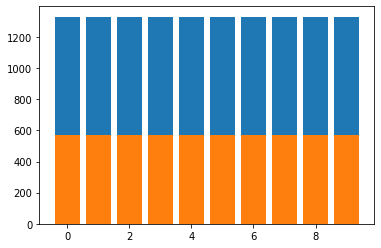

In [0]:
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [0]:
input_shape = X_train[0].shape
num_genres = 10

model = Sequential()
#implementação da concolução 2D
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
#implementação de MAxPooling para reduzir o tamanho da imagem
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#implementação de DropOut
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(Dropout(0.2))
#Flatten para transformar a imagem em array
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))



In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/50
13300/13300 [==============================] - 7s 540us/step - loss: 2.0771 - acc: 0.2567 - val_loss: 1.7607 - val_acc: 0.3667
Epoch 2/50
13300/13300 [==============================] - 6s 447us/step - loss: 1.6090 - acc: 0.4221 - val_loss: 1.5752 - val_acc: 0.4272
Epoch 3/50
13300/13300 [==============================] - 6s 447us/step - loss: 1.4532 - acc: 0.4867 - val_loss: 1.3614 - val_acc: 0.5111
Epoch 4/50
13300/13300 [==============================] - 6s 447us/step - loss: 1.3087 - acc: 0.5459 - val_loss: 1.1739 - val_acc: 0.6107
Epoch 5/50
13300/13300 [==============================] - 6s 445us/step - loss: 1.2171 - acc: 0.5813 - val_loss: 1.0525 - val_acc: 0.6484
Epoch 6/50
13300/13300 [==============================] - 6s 445us/step - loss: 1.1421 - acc: 0.6138 - val_loss: 1.0527 - val_acc: 0.6623
Epoch 7/50
13300/13300 [==============================] - 6s 443us/step - loss: 1.0581 - acc: 0.6397 - val_loss: 0.9971 - v

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.439 and val_acc = 0.861


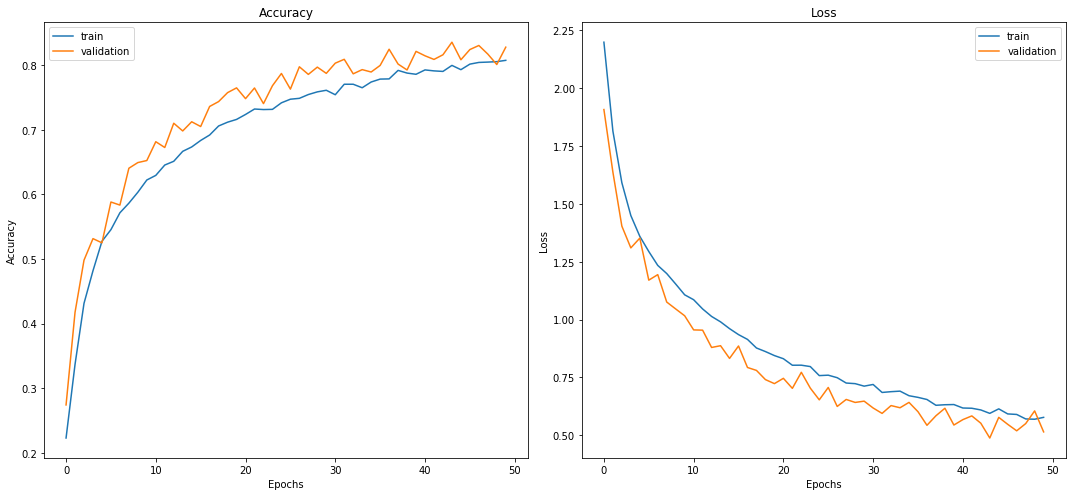

In [0]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[542   3   1  21   0   2   9   5   1  36]
 [  0 518   0   8   0   7  16   1  23  27]
 [  0   8 550   0  39   7   9   2   6  10]
 [  4   1   0 502   0   0  19   7  17   5]
 [  1   0  14   0 510  28   4  21  11  10]
 [  2   7   0   3   6 419  17  17   7  26]
 [  0   7   0  15   0   4 449   2   3   2]
 [  0   0   1   3   5   8   3 479   5   2]
 [  0   3   0   9   2   9   6  22 494   7]
 [ 21  23   4   9   8  86  38  14   3 445]]


Confusion matrix, without normalization


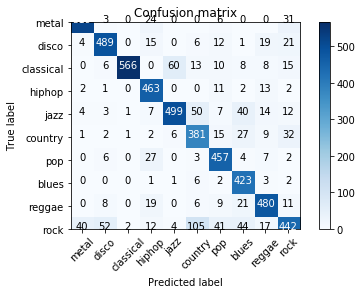

In [0]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

#plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=False)